# Computer Vision

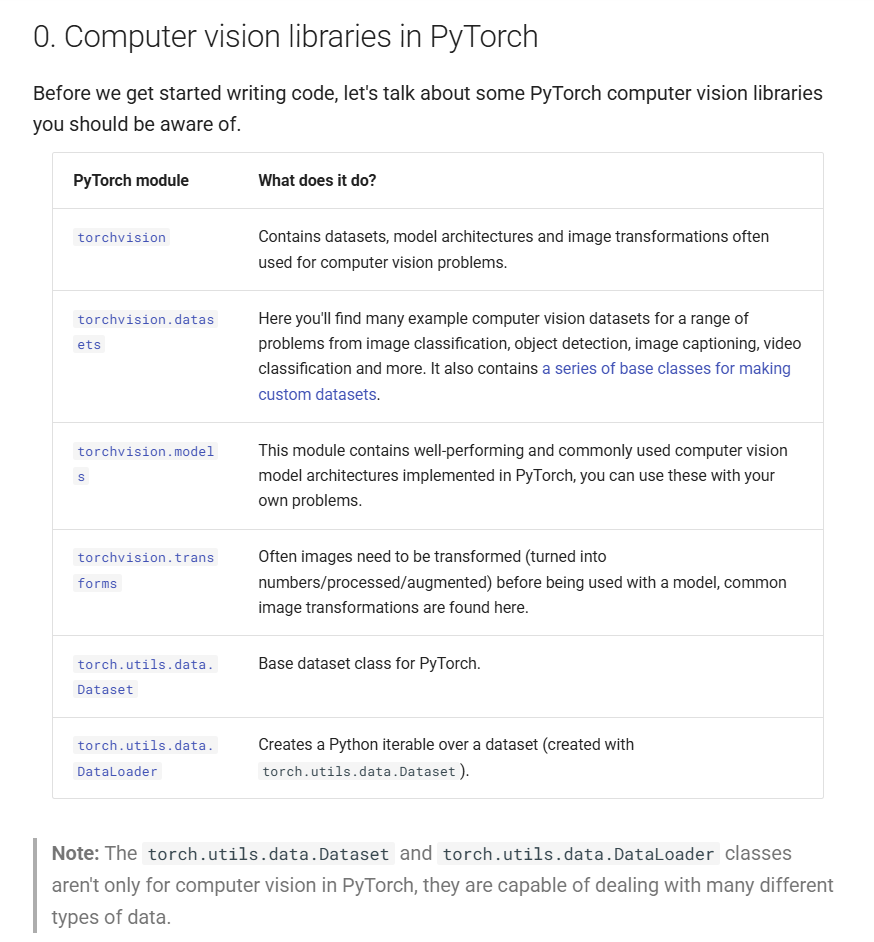

In [103]:
# Imports
import torch
from torch import nn
import matplotlib.pyplot as plt

import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


In [104]:
# Setup training data
train_dataset = datasets.FashionMNIST(root='./data',
                                      train=True, # get the traindata
                                      download=True,
                                      transform=ToTensor(),
                                      target_transform=None)

# Setup testing data
test_dataset = datasets.FashionMNIST(root='./data',
                                     train=False, # get the test data and not train data
                                     download=True,
                                     transform=ToTensor())

In [120]:
image,label = train_dataset[0]
print(f'image: {image}')
print(f'labels: {label}')

image: tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 

In [106]:
image.shape # shape = [color_channels = 1, height = 28, width = 28] color_channels =              1 is greyscale image, color_channels=3 is RGB image

torch.Size([1, 28, 28])

In [107]:
len(train_dataset.data),len(train_dataset.targets),len(test_dataset.data),len(test_dataset.targets)

(60000, 60000, 10000, 10000)

In [108]:
#Class names:  Multi-class classification
classes= train_dataset.classes
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

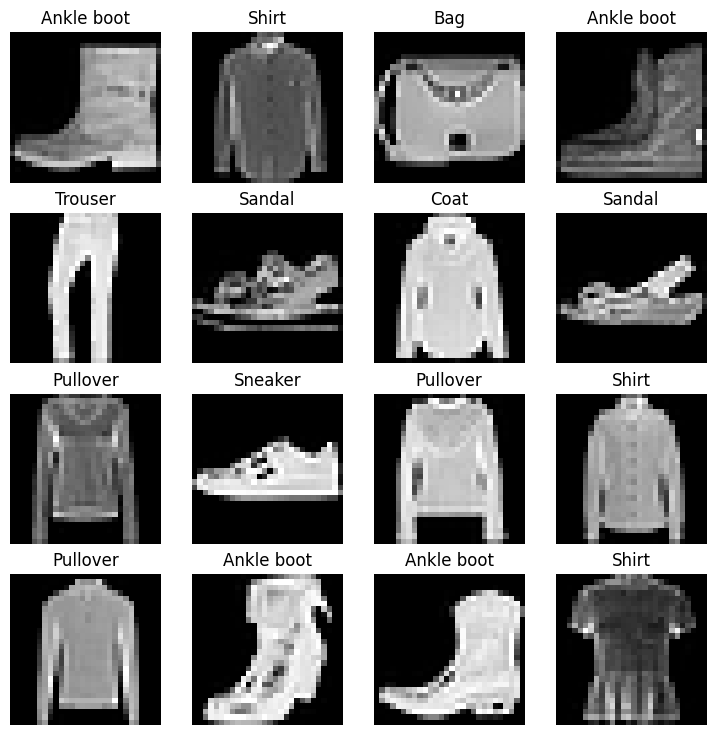

In [109]:
# Visualize image on pyplot
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(classes[label])
    plt.axis(False)

### Basic Workflow for computer Vision Problems
###### Input the data set -> Convert the images to Tensors  and make the data train ready by performing pre-processing -> Pass these tensors to selected/built model -> model analyzes the tensors and builds a pattern -> returns the prediction in the form of  tensors based on these patterns -> these tensors are converted back to images to be viewable for the end users or later processed

### DataLoader
 dataloader: loads the data on ur model file for training and validation It turns the big data into small chunks of python iterables. These chunks are called as batches and can be set by batch_size. These batches divide the data so that it is easier for the model and ur computer to load small data chunks instead giving all u data to the forward pass which costs high computational power in reality when working with larger datasets. With mini-batches (small portions of the data), gradient descent is performed more often per epoch (once per mini-batch rather than once per epoch). Btch size comes under Hyperparametrs and can be set by ml engineers


In [110]:
# Creation of dataloader

#Set the batch size
batch_size = 32

#Load the training data
train_dataloader = DataLoader(
                              train_dataset, #load the data
                              batch_size=batch_size, # samples per batch
                              shuffle=True # shuffle data every epoch
                              )

#Load the testing data
test_dataloader = DataLoader(
                              test_dataset, #load the data
                              batch_size=batch_size, # samples per batch
                              shuffle=False # shuffle data every epoch is not necessary
                              )
len(train_dataloader),len(test_dataloader) # give u size of each batch

(1875, 313)

Next step is to create  a baseline model which can be later improved. This model will contain 2 layers. There would be nn.Linear layer and nn.Flatten where it would convert the dimensions into a vector. Before shape: [1,28,28]. After Flattening: [1,28*28] = [1,784] --> [color_channel,height*width]. This new quantity is called as feature vector. The heighxwidth defines the pixel area covered by the image. Thus our input features in are dataset would contain heighxwidth values for each pixel .

In [111]:
from torch import nn

# basic model
class Model(nn.Module):
    def __init__(self, input_features:int, out_features:int, hidden_features:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),# this to convert the pixel shape in long/feature vector shape
            nn.Linear(input_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, out_features),
            nn.ReLU()
        )
    def forward(self, x):
        return self.layer_stack(x)

In [112]:
# initialize the model instance
torch.manual_seed(42)

model  = Model(input_features=784, # total pixels will be input features. Total pixels = height * width                                     of shape
               out_features=len(classes), # number of labels
               hidden_features=10)
model

Model(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [113]:
from helper_functions import accuracy_fn # accuracy function from helper function

#loss function
loss_fn = nn.CrossEntropyLoss()
#Optimizer
optimizer = torch.optim.SGD(params = model.parameters(), lr=0.01)

In [114]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [115]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss_total, train_acc = 0, 0
    model.to(device)
    for batch, (X, Y) in enumerate(data_loader):
        # Send data to GPU
        X, Y = X.to(device), Y.to(device)

        # 1. Forward pass
        train_predcition = model(X)

        # 2. Calculate loss
        train_loss = loss_fn(train_predcition, Y)
        train_loss_total+= train_loss
        train_acc += accuracy_fn(y_true=Y,
                                 y_pred=train_predcition.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        train_loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss_total /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss_total:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss_total, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, Y in data_loader:
            # Send data to GPU
            X, Y = X.to(device), Y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss_total += loss_fn(test_pred, Y)
            test_acc += accuracy_fn(y_true=Y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss_total /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss_total:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [116]:
from tqdm import tqdm

# Execution step
torch.manual_seed(42)
#set epoch
epochs = 10
for epoch in tqdm(range(epochs)):
    #Training ...
    train_step(model = model,
               data_loader = train_dataloader,
               optimizer=optimizer,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model = model,
              data_loader = test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 1.42179 | Train accuracy: 54.29%


 10%|█         | 1/10 [00:16<02:30, 16.74s/it]

Test loss: 1.12168 | Test accuracy: 62.15%

Train loss: 1.03359 | Train accuracy: 64.61%


 20%|██        | 2/10 [00:35<02:21, 17.71s/it]

Test loss: 1.00019 | Test accuracy: 64.48%

Train loss: 0.95996 | Train accuracy: 66.05%


 30%|███       | 3/10 [00:50<01:58, 16.86s/it]

Test loss: 0.96338 | Test accuracy: 65.41%

Train loss: 0.92878 | Train accuracy: 66.59%


 40%|████      | 4/10 [01:06<01:38, 16.38s/it]

Test loss: 0.93870 | Test accuracy: 65.94%

Train loss: 0.91090 | Train accuracy: 67.04%


 50%|█████     | 5/10 [01:21<01:19, 15.89s/it]

Test loss: 0.92726 | Test accuracy: 65.99%

Train loss: 0.89804 | Train accuracy: 67.28%


 60%|██████    | 6/10 [01:39<01:06, 16.56s/it]

Test loss: 0.91716 | Test accuracy: 66.25%

Train loss: 0.88839 | Train accuracy: 67.59%


 70%|███████   | 7/10 [01:59<00:52, 17.55s/it]

Test loss: 0.90851 | Test accuracy: 66.63%

Train loss: 0.88084 | Train accuracy: 67.67%


 80%|████████  | 8/10 [02:15<00:34, 17.17s/it]

Test loss: 0.90477 | Test accuracy: 66.39%

Train loss: 0.87435 | Train accuracy: 67.83%


 90%|█████████ | 9/10 [02:33<00:17, 17.58s/it]

Test loss: 0.89880 | Test accuracy: 66.73%

Train loss: 0.86862 | Train accuracy: 67.94%


100%|██████████| 10/10 [02:52<00:00, 17.22s/it]

Test loss: 0.89754 | Test accuracy: 66.82%

